# Fundamental Analysis

In [1]:
import pandas as pd
from vnstock import Vnstock
# Set date range
start_date = '2024-01-01'
end_date = '2025-03-19'
interval = '1D'
symbol='REE'
stock = Vnstock().stock(symbol=symbol, source='VCI')



## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                

In [2]:
CashFlow = stock.finance.cash_flow(period='year')


## Transpose the CF dataframe 

In [3]:
#CashFlow
CashFlow_transposed = CashFlow.T
CashFlow_transposed.columns = CashFlow['yearReport']
# Drop the duplicate 'yearReport' row
CashFlow_transposed = CashFlow_transposed.drop('yearReport')
CashFlow_transposed.head()

yearReport,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
ticker,REE,REE,REE,REE,REE,REE,REE,REE,REE,REE,REE,REE
Net Profit/Loss before tax,2687606595302,3056093471161,3878561080509,2399829028939,1923585472508,1920209997754,2118013069944,1721146987668,1375753903562,1045676170298,1262427405945,1087556959984
Depreciation and Amortisation,1298493472359,1263900546872,1225256688185,892746007729,321516852418,182619094137,161304336971,130117592892,139556922833,132711178140,57142979454,61183861575
Provision for credit losses,94886966817,267350820613,98981408043,18405779937,23057787014,-37003997619,-181821279821,63225518370,-7712055856,8470325013,-26958372500,36502068928
Unrealized foreign exchange gain/loss,13364760,34472956246,42356802295,-54068058823,51724431455,141521813,180374946,283085334,279701943,-29384453,1641418011,4239193028


# Convert the built-in visulization method to seaborn for a more polished look

In [4]:
Ratio = stock.finance.ratio(period='year', dropna=True)


### Transpose the data frame to display on the web.

In [5]:
Ratio_transposed = Ratio.T
Ratio_transposed.columns=Ratio_transposed.iloc[1]
Ratio_transposed = Ratio_transposed.iloc[3:]

In [6]:
# Example: Select the 'ROE (%)' column under 'Chỉ tiêu khả năng sinh lợi'
dividend_yield = Ratio[('Chỉ tiêu khả năng sinh lợi', 'Dividend yield (%)')]
Outstanding_Shares = Ratio[('Chỉ tiêu định giá', 'Outstanding Share (Mil. Shares)')]


### Transform the balance sheet from long format to wide format. 

In [7]:
def BS_wide(stock=None):
    """
    Transform balance sheet data into a wide format with years as columns and metrics as rows.
    
    Parameters:
    -----------
    stock : object, default=None
        The stock ticker object containing financial data.
        If None, will create a default stock object for REE from VCI source.
    
    Returns:
    --------
    pandas.DataFrame
        Transformed balance sheet with years as columns and financial metrics as rows
    """
    
    # Create default stock object if not provided
    if stock is None:
        stock = Vnstock().stock(symbol='REE', source='VCI')
    
    # Get the balance sheet data
    BS = stock.finance.balance_sheet(period='year', lang='en', dropna=True)
    
    # Transpose the DataFrame
    BS_wide = BS.T
    
    # Promote header by setting column names using the second row (index 1)
    BS_wide.columns = BS_wide.iloc[1]
    
    # Keep only the data rows (skip the first 3 rows)
    BS_wide = BS_wide.iloc[3:]
    
    return BS_wide

In [8]:
BalanceSheet = stock.finance.balance_sheet(period='year', lang='en', dropna=True)
BalanceSheet_Transposed = BalanceSheet.T
BalanceSheet_Transposed.columns = BalanceSheet_Transposed.iloc[1]
BalanceSheet_Transposed = BalanceSheet_Transposed.iloc[3:]
BalanceSheet_Transposed.head()

yearReport,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
Cash and cash equivalents (Bn. VND),5635908856765,3022796235406,1151270686145,1830901134902,651668665185,1539577051904,1865096744967,2397186656336,960027120496,1419715236964,1036655683725,535795614565
Short-term investments (Bn. VND),1060073372989,1132366903888,1749361611727,913528242575,1328559221660,1221295628590,1138925962847,516561743653,749169998917,381491325362,249589701655,416693781070
Accounts receivable (Bn. VND),3129681988376,3780066002722,4013295895776,2986542167652,3082281525922,2137973891941,1965707145074,1130676903999,1148403790279,1368936569867,1029983840576,1002628925985
Net Inventories,1276815964044,1353834235393,1408572015872,799900814968,807507044477,987203880889,969073762968,1555629874625,1230323799872,547093860649,598432151160,544225294953
Other current assets,183295042421,235115020118,250979175707,275099902031,138617308711,112997235133,48880854277,51296869224,17305145779,30168992774,13932647991,62597867219


### Transform Income statement from long format to wide format. 

In [9]:
IncomeStatement = stock.finance.income_statement(period='year', lang='en', dropna=True)
IncomeStatement_Transpose= IncomeStatement.T
IncomeStatement_Transpose.columns = IncomeStatement_Transpose.iloc[1]
IncomeStatement_Transpose = IncomeStatement_Transpose.iloc[3:]
IncomeStatement_Transpose.head()

yearReport,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
Revenue (Bn. VND),8394604176003,8579347840237,9377949892489,5815207697974,5644088890450,4896700913533,5104605853407,4999235436523,3663193468551,2645193904607,2630675383788,2414569501626
Attribute to parent company (Bn. VND),1993385852649,2188316658468,2692516590418,1855079628131,1628076208584,1638893522530,1783971852557,1377087391977,1093237014487,853082411270,1061971178941,975819282949
Attribute to parent company YoY (%),-0.089078,-0.18726,0.451429,0.13943,-0.0066,-0.081323,0.295467,0.259642,0.281514,-0.196699,0.088287,0.0
Financial Income,317755694465,227055551430,186791709886,466044378716,221805860261,441971991367,303525295129,174539941233,176056435309,427537034206,459521649291,352660891530
Interest Expenses,-737977126660,-938879965835,-882746948990,-663213132564,-416425845956,-409016686932,-224927404624,-104642480959,-60159491918,-73966770226,-37413873577,-57146113236


In [10]:
# import os
# import pandas as pd

# def save_financial_statements_to_csv(balance_sheet_df, income_statement_df, cashflow_df, output_dir='./outputs'):
#     """
#     Save financial statements DataFrames to CSV files in the specified output directory.
    
#     Parameters:
#     -----------
#     balance_sheet_df : pandas.DataFrame
#         Balance Sheet DataFrame
#     income_statement_df : pandas.DataFrame
#         Income Statement DataFrame
#     cashflow_df : pandas.DataFrame
#         Cash Flow Statement DataFrame
#     output_dir : str
#         Directory path where CSV files will be saved (default: './outputs')
#     """
    
#     # Create output directory if it doesn't exist
#     try:
#         os.makedirs(output_dir, exist_ok=True)
#         print(f"Output directory '{output_dir}' is ready.")
#     except Exception as e:
#         print(f"Error creating directory: {e}")
#         return
    
#     # Dictionary of DataFrames and their corresponding filenames
#     statements = {
#         'REE_BalanceSheet_Transposed.csv': balance_sheet_df,
#         'REE_IncomeStatement_Transpose.csv': income_statement_df,
#         'REE_CashFlow_transposed.csv': cashflow_df
#     }
    
#     # Save each DataFrame to CSV
#     for filename, df in statements.items():
#         try:
#             file_path = os.path.join(output_dir, filename)
#             df.to_csv(file_path)
#             print(f"Successfully saved {filename}")
#         except Exception as e:
#             print(f"Error saving {filename}: {e}")

# # Example usage:
# # save_financial_statements_to_csv(
# #     BalanceSheet_Transposed,
# #     IncomeStatement_Transpose,
# #     CashFlow_transposed
# # )

In [11]:
from vnstock import Vnstock
import warnings
warnings.filterwarnings("ignore")
symbol = 'REE'
company = Vnstock().stock(symbol=symbol, source='TCBS').company



2025-05-21 17:44:05 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.


# Event Impact Analysis

In [ ]:
events = stock.company.events()
dividend_events = events[events['event_list_name'] == 'Trả cổ tức bằng tiền mặt']
dividend_events = dividend_events.dropna()


          id                                        event_title  \
14     30225   REE-Trả cổ tức Đợt 1, 2017 bằng tiền 1600 VND/CP   
15     30226  REE - Trả cổ tức Đợt 1, 2018 bằng tiền 1800 VN...   
16     30227  REE - Trả cổ tức Đợt 1, 2019 bằng tiền 1600 VN...   
17   5784800  REE - Trả cổ tức Cả năm năm 2021 bằng tiền 100...   
18  18503180  REE - Trả cổ tức Đợt 1 năm 2022 bằng tiền 1000...   
22  36274685  REE - Trả cổ tức Cả năm năm 2023 bằng tiền 100...   
23  51209466  REE - Trả cổ tức Đợt 1 năm 2024 bằng tiền 1000...   

                                      en__event_title public_date  issue_date  \
14  REE-Pays Interim 1, 2017 cash dividend at VND1...  2018-02-05  2018-04-27   
15  REE - Pays Interim 1, 2018 cash dividend at VN...  2019-02-15  2019-04-05   
16  REE - Pays Interim 1, 2019 cash dividend at VN...  2020-02-14  2020-04-10   
17  REE - Pay cash dividend 2021 - Year at VND 100...  2022-04-07  2022-04-29   
18  REE - Pay cash dividend 2022 - Interim 1 at VN...  202

In [13]:
# Convert from object to datetime
dividend_events['exright_date'] = pd.to_datetime(dividend_events['exright_date'])
dividend_events = dividend_events.set_index('exright_date')

In [14]:
# Loop through each dividend event
for index, event in dividend_events.iterrows():
    # Since exright_date is now the index, we use the index directly
    exright_date = index
    
    # Calculate the time window (30 days before and after the ex-dividend date)
    exercise_start_date = exright_date - pd.Timedelta(days=30)
    exercise_end_date = exright_date + pd.Timedelta(days=30)
    
    # Convert dates to the required string format 'YYYY-MM-DD'
    exercise_start_str = exercise_start_date.strftime('%Y-%m-%d')
    exercise_end_str = exercise_end_date.strftime('%Y-%m-%d')
    
    # Get price history around the event
    event_prices = stock.quote.history(start=exercise_start_str, end=exercise_end_str, interval='1D')

In [15]:
import plotly.graph_objects as go

# Create a candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=event_prices.index,
    open=event_prices['open'],
    high=event_prices['high'],
    low=event_prices['low'],
    close=event_prices['close']
)])

# Update layout
fig.update_layout(
    title='Candlestick Chart',
    yaxis_title='Price',
    xaxis_title='Date'
)

fig.show()

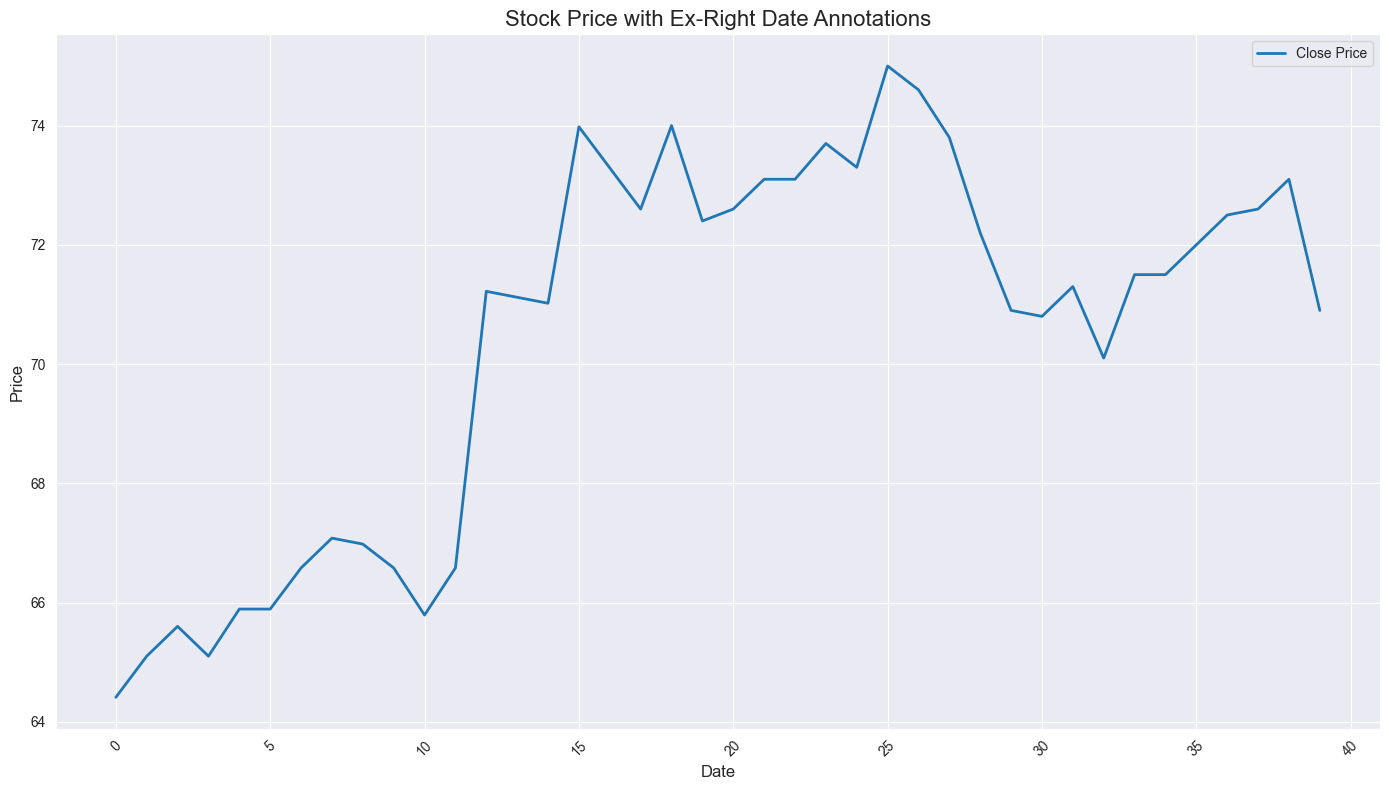

In [16]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(14, 8))

# Create a line chart with seaborn for the price data
sns.lineplot(data=event_prices['close'], linewidth=2, label='Close Price')

# Annotate the exright dates
for date in dividend_events.index:
    if date in event_prices.index or np.datetime64(date) in event_prices.index:
        # Find the corresponding price on that date
        if date in event_prices.index:
            price = event_prices.loc[date, 'close']
        else:
            # Find the closest date if exact match not found
            closest_date = event_prices.index[event_prices.index.get_indexer([date], method='nearest')[0]]
            price = event_prices.loc[closest_date, 'close']
        
        # Annotate the exright date with a vertical line
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.7)
        plt.annotate('Ex-Right Date', 
                     xy=(date, price),
                     xytext=(date, price*1.05),  # Slightly above the price
                     arrowprops=dict(facecolor='red', shrink=0.05),
                     fontsize=10,
                     ha='center')
        
        # Add markers for exercise start and end dates
        start_date = date - pd.Timedelta(days=30)
        end_date = date + pd.Timedelta(days=30)
        
        # Find prices for start and end dates
        if start_date in event_prices.index:
            start_price = event_prices.loc[start_date, 'close']
        else:
            closest_start = event_prices.index[event_prices.index.get_indexer([start_date], method='nearest')[0]]
            start_price = event_prices.loc[closest_start, 'close']
            
        if end_date in event_prices.index:
            end_price = event_prices.loc[end_date, 'close']
        else:
            closest_end = event_prices.index[event_prices.index.get_indexer([end_date], method='nearest')[0]]
            end_price = event_prices.loc[closest_end, 'close']
        
        # Annotate exercise start and end dates
        plt.axvline(x=start_date, color='green', linestyle=':', alpha=0.5)
        plt.annotate('Exercise Start', 
                     xy=(start_date, start_price),
                     xytext=(start_date, start_price*0.95),
                     arrowprops=dict(facecolor='green', shrink=0.05),
                     fontsize=9,
                     ha='center')
        
        plt.axvline(x=end_date, color='blue', linestyle=':', alpha=0.5)
        plt.annotate('Exercise End', 
                     xy=(end_date, end_price),
                     xytext=(end_date, end_price*0.95),
                     arrowprops=dict(facecolor='blue', shrink=0.05),
                     fontsize=9,
                     ha='center')

# Customize the plot
plt.title('Stock Price with Ex-Right Date Annotations', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

# Display the plot
plt.show()

In [17]:
CashFlow['Dividends paid']

0    -1026622785445
1     -886399583241
2     -574485123284
3      -85585440392
4     -604308347572
5     -619965858741
6     -601660154901
7     -597101775379
8     -293364286368
9     -509787632500
10    -419830953186
11    -386733996880
Name: Dividends paid, dtype: int64

In [19]:
# Levered Free Cash Flow (accounts for debt repayments/receipts)
CashFlow['Levered Free Cash Flow'] = (
    CashFlow['Net cash inflows/outflows from operating activities'] 
    - CashFlow['Purchase of fixed assets']
    + CashFlow['Proceeds from disposal of fixed assets']
    - (CashFlow['Repayment of borrowings'] - CashFlow['Proceeds from borrowings'])
)

In [20]:
dividend_coverage_ratio = CashFlow['Levered Free Cash Flow'] / CashFlow['Dividends paid'].abs()

In [ ]:
from vnstock import Vnstock
company = Vnstock().stock(symbol=symbol,source="TCBS").company
company.dividends()

2025-05-21 17:37:30 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.


,exercise_date,cash_year,cash_dividend_percentage,issue_method
0,2025-02-27,2024,0.10,cash
1,2024-05-21,2024,0.15,share
2,2024-04-12,2023,0.10,cash
3,2023-05-19,2023,0.15,share
4,2023-02-28,2022,0.10,cash
5,2022-05-17,2022,0.15,share
6,2022-04-19,2021,0.10,cash
7,2020-03-02,2019,0.16,cash
8,2019-02-26,2018,0.18,cash
9,2018-02-28,2017,0.16,cash


In [ ]:
reciprocal_tariffs_date = '2025-04-02'
baseline_tariffs_date = '2025-04-09'
china_negotiation_date = '2025-05-12'
deal_achieved_date = '2025-05-15'